In [12]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl
import scipy.stats as spstats

In [13]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.scatter as sct

In [14]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
pplot.set_plot_params()
scatter_kws={'s':2}

In [15]:
# Metadata
visual_areas=['V1', 'Lm', 'Li']
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


## Select dataset and create output dirs

In [62]:
# dk = '20191111_JC117_fov1
# dk ='20190617_JC097_fov1'
# dk = '20191006_JC110_fov1'
# dk = '20190522_JC084_fov1'
traceid='traces001'

In [63]:
# RF settings
is_neuropil=True
response_type='dff'
do_spherical_correction=False
fit_thr=0.5
experiment='rfs'

# Load gradient results

In [169]:
dk='20190509_JC078_fov1'
va='Lm'
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                            create_new=True)

... calculating global gradients (20190509_JC078_fov1, Lm)


#### Check gradients

    found: 20190509_JC078_fov1, Lm dict_keys(['Lm', 'V1'])


<IPython.core.display.Javascript object>


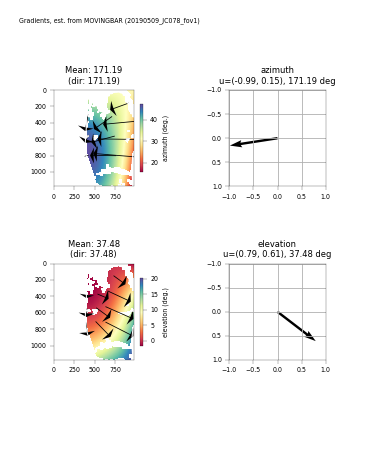

Text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (20190509_JC078_fov1)')

In [170]:
%matplotlib notebook
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral')
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

#### Load Neuropil data points

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.817984 | 3.03277 | 8.67922e-65 |   -0.904425 |    -0.0409018 |    66.8604  | az     |
|  1 | 0.329949 | 4.49994 | 1.74201e-16 |    0.574412 |     0.0126621 |    -1.72174 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.707714 | 3.84316 | 2.84339e-47 |   -0.841257 |    -0.036392  |     60.1614 | az     |
|  1 | 0.834397 | 2.23711 | 2.79095e-68 |    0.913453 |     0.0272071 |    -19.0103 | el     |


<IPython.core.display.Javascript object>


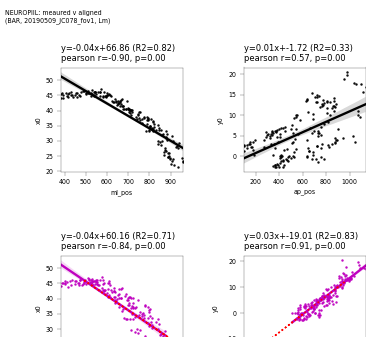

Text(0.01, 0.95, 'NEUROPIIL: meaured v aligned\n(BAR, 20190509_JC078_fov1, Lm)')

In [185]:
mag_thr=0.001
delay_map_thr=1.0
ds_factor=2
# # 1. Load neuropil background prefs
# retinodf_np = sct.load_neuropil_data(dk, retinorun, mag_thr=mag_thr, 
#                                 delay_map_thr=delay_map_thr, ds_factor=ds_factor)
# # 2. Align FOV to gradient vector direction 
# curr_np = retinodf_np[retinodf_np.visual_area==va].copy()
# aligned_, M = sct.project_onto_gradient(curr_np, GVECTORS,
#                                   xlabel='ml_pos', ylabel='ap_pos')
# aligned_np = pd.concat([retinodf_np, aligned_], axis=1).dropna()

# # 3. Use NEUROPIL to estimate linear model
# REGR_NP = sct.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')
# regr_np_meas = sct.regress_cortex_and_retino_pos(aligned_np, xvar='pos', model='ridge')
aligned_np, REGR_NP, regr_np_meas = sct.transform_and_align_neuropil(dk, va, retinorun,
                                                    GVECTORS, mag_thr=mag_thr, 
                                                    delay_map_thr=delay_map_thr, 
                                                    ds_factor=ds_factor)
# Save
# sct.update_models(dk, va, REGR_NP)

# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

%matplotlib notebook
fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)
fig.text(0.01, 0.95, 'NEUROPIIL: meaured v aligned\n(BAR, %s, %s)' % (dk, va))

#### Load soma

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.835384 | 3.85395 |  0.0298846  |   -0.913993 |    -0.0614898 |    84.2942  | az     |
|  1 | 0.956602 | 2.22374 |  0.00388813 |    0.97806  |     0.0397397 |    -0.84953 | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.230845 | 8.33062 |   0.412682  |   -0.480463 |    -0.0310116 |     54.6478 | az     |
|  1 | 0.895335 | 3.45344 |   0.0148496 |    0.946221 |     0.0474688 |    -25.3172 | el     |


<IPython.core.display.Javascript object>


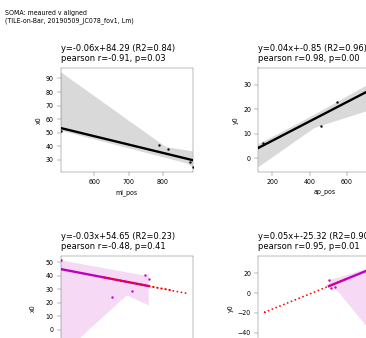

In [186]:
#### Align soma coords to gradient
aligned_soma = sct.predict_soma_from_gradient(dk, va, REGR_NP, experiment=experiment,
                                   response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
#### (alrady done above, but get regr. values)
regr_soma_meas = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                   xvar='pos', model='ridge')
regr_soma_proj = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                    xvar='proj', model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED:")
print(regr_soma_proj.to_markdown())
# plot
fig = sct.plot_measured_and_aligned(aligned_soma, regr_soma_proj, regr_soma_meas)
fig.text(0.01, 0.95, 'SOMA: meaured v aligned\n(TILE-on-Bar, %s, %s)' % (dk, va))
pl.subplots_adjust(right=0.8, bottom=0.2)
# figname = 'compared_measured_vs_aligned_CTX_to_RETINO'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Plot

In [187]:
# output dir
rf_str = 'sphr_corrected' if do_spherical_correction else ''
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter/%s' % rf_str)
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'retinotopy', 'scatter/%s' % rf_str)
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

print(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/retinotopy/scatter/


## predicted_vs_measured_fov_overlay

In [188]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, traceid=traceid)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)

In [189]:
inbounds_soma = aligned_soma[aligned_soma.inbounds].copy()

In [194]:
# Make sure we are in bounds of FOV
ap_lim, ml_lim = AZMAP_NP.shape
print(ap_lim, ml_lim)
incl_plotdf = inbounds_soma[(inbounds_soma['predicted_ml_pos']>=0) 
                            & (inbounds_soma['predicted_ml_pos']<=ml_lim) 
                            & (inbounds_soma['predicted_ap_pos']>=0)
                            & (inbounds_soma['predicted_ap_pos']<=ap_lim)].copy()
excl_ixs = [i for i in inbounds_soma.index.tolist() if i not in incl_plotdf.index]
plotdf = incl_plotdf.iloc[0::].copy()

vmin = min([np.nanmin(AZMAP_NP), plotdf['x0'].min()])
vmax = max([np.nanmax(AZMAP_NP), plotdf['x0'].max()])
print("AZ: min/max = %.2f, %.2f" % (vmin, vmax))
vmin = min([np.nanmin(ELMAP_NP), plotdf['y0'].min()])
vmax = max([np.nanmax(ELMAP_NP), plotdf['y0'].max()])
print("EL: min/max = %.2f, %.2f" % (vmin, vmax))


1177 972
AZ: min/max = 15.82, 46.96
EL: min/max = -1.50, 20.19


In [195]:
az_min=5
az_max=30
el_min=-30
el_max=-5

<IPython.core.display.Javascript object>


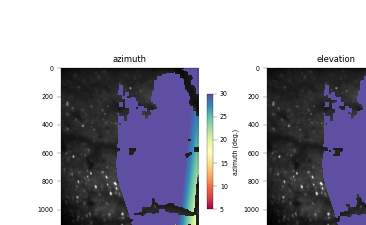

AttributeError: 'NoneType' object has no attribute 'remove'

In [196]:
roi_interval = 1
cmap='Spectral'
plot_true=True
plot_predicted=False
plot_lines=True

color_true='k'
color_predicted='w'

markersize=30
lw=0.7
alpha=1

fig, axn = pl.subplots(1, 2, figsize=(6.5,4))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_NP.copy() if cond=='azimuth' else ELMAP_NP.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = az_min if cond=='azimuth' else el_min #min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = az_max if cond=='azimuth' else el_max #max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    sm = pl.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.figure.colorbar(sm, ax=ax, shrink=0.5, label='%s (deg.)' % cond)
    
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x='predicted_ml_pos', y='predicted_ap_pos', 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_predicted, zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[['predicted_ml_pos', 'predicted_ap_pos']].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_true, zorder=1000) 
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)

# figname = 'scatter_example_%s' % dk
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

# Calculate scatter

In [42]:
# Load scatter analysis for current FOV
scatter0 = sct.load_scatter_results(dk, va, experiment, verbose=False)
# Get cells with reliable fits
fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                do_spherical_correction=do_spherical_correction)
eval_results, eval_params = rfutils.load_eval_results(dk, experiment=experiment, 
                                traceid=traceid, fit_desc=fit_desc)   
reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                pass_criterion='position')
# Assign reliable index
found_rois = scatter0['cell'].unique()
scatter0['reliable'] = False
scatter0.loc[scatter0['cell'].isin(reliable_), 'reliable'] = True

In [43]:
# Identify "true deviants"
devs_ = sct.get_deviants_in_fov(dk, va, experiment=experiment, redo_fov=False,
                     traceid=traceid, response_type=response_type, 
                     do_spherical_correction=do_spherical_correction)               
devs_ = devs_.rename(columns={'deviants': 'cell'})
devs_['deviant'] = True
# merge
scatter_ = scatter0.merge(devs_, on=['cell', 'axis'], how='outer')
scatter_ = scatter_.fillna(value=False).sort_values(by=['cell', 'axis'])\
                   .reset_index(drop=True)

In [44]:
# Only get reliable
rois_ = np.intersect1d(reliable_, aligned_soma[aligned_soma.inbounds]['cell'].unique())
boot_ = eval_results['bootdf'][eval_results['bootdf']['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]
fitrfs_ = aligned_soma[aligned_soma['cell'].isin(rois_)].copy()
fitrfs_.index = fitrfs_['cell'].values

<IPython.core.display.Javascript object>


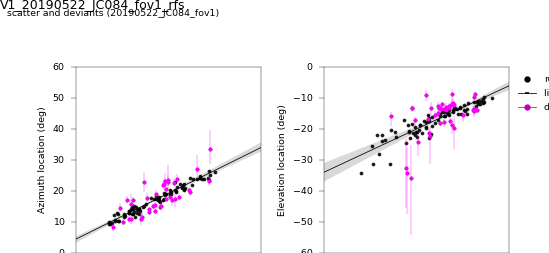

In [45]:
%matplotlib notebook
ci = 0.95
fill_marker=True
deviant_color='magenta'

fig, axn = pl.subplots(1, 2, figsize=(6.5,3), dpi=150, sharex=True)
for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
    if cond=='az':
        ax.set_ylim([0, 60])
    else:
        #pass
        ax.set_ylim([-60, -0])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    ax.set_xlim([-10, 1250])
    # Get projected cortical position
    ax, devs_ = sct.fit_with_deviants(boot_, cis_, fitrfs_, 
                          xname=xname, yname=yname, ax=ax,
                          scatter_kws={'s': 2, 'marker': 'o'}, line_kws={'lw': 0.5}, 
                          deviant_color=deviant_color)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cortical position (um)')
    devdf = pd.DataFrame({'deviants': devs_})
    devdf['cond'] = cond
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.75, bottom=0.25, top=0.85, wspace=0.3)

leg_h = pplot.custom_legend_markers(colors=['k', 'k', 'm'],
                    labels=['reliable', 'linear fit (95% CI)', 'deviant (95% CI)'],
                    markers=['o', '_', 'o'], lws=[0, 0.5, 0.5])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left',
          frameon=False, fontsize=6, markerscale=0.5)

pl.subplots_adjust(left=0.1, right=0.7, bottom=0.25, top=0.8)

fig.text(0.01, 0.95, 'scatter and deviants (%s)' % dk)
pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))

figname = 'deviants_example_%s' % dk
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


In [46]:
fitrfs_[(fitrfs_.x0>20) & (fitrfs_.ml_proj<600)]

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds
72,23.223453,-13.379585,47.053317,18.627193,6.281722,-0.004755,0.048695,0.633482,72,V1,...,864.915011,18.757578,-16.421321,862.498547,488.877646,4.465875,3.041736,258.362763,273.410594,True
78,22.671336,-24.079966,37.873614,28.493340,6.021655,-0.006283,0.083996,0.732004,78,V1,...,-96.903348,16.331038,-18.691489,813.424591,-605.792203,6.340298,-5.388477,366.803117,484.350627,True
93,21.926744,-21.039890,19.400287,29.726939,0.083663,-0.015322,0.329222,0.942812,93,V1,...,176.357990,18.517913,-16.169139,775.698568,-263.502498,3.408830,-4.870751,197.209903,437.814087,True
134,22.214619,-13.138211,27.423279,18.489837,6.259620,-0.012023,0.170968,0.785663,134,V1,...,886.611181,18.655993,-12.846540,805.068651,549.013381,3.558626,-0.291672,205.875983,26.217322,True


In [47]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

<IPython.core.display.Javascript object>


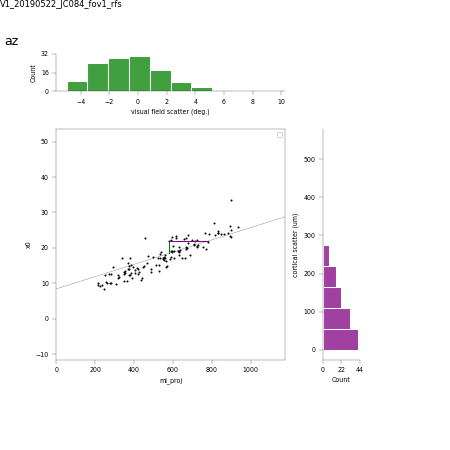

No handles with labels found to put in legend.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>


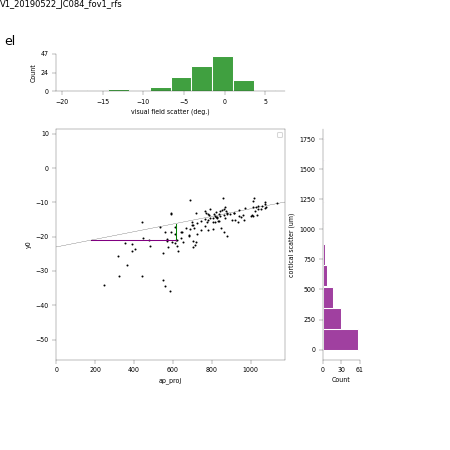

No handles with labels found to put in legend.


In [48]:
sz = 3
lw=0.5
nbins=10
color1='purple'
color2='green'

for cond in ['az', 'el']:
    dist_lim = ml_lim if cond=='az' else ap_lim
    fig = sct.plot_scatter_and_marginals(fitrfs_, REGR_NP, roi_to_label=93,
                                         cond=cond,
                                        xlim=ap_lim, ylim=None, lw=1)
    pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))
    fig.text(0.01, 0.9, '%s' % cond, fontsize=12)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    figname = 'scatter_marginals_%s_%s' % (cond, dk)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


In [298]:
fitrfs_[fitrfs_['cell']==78]

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds
78,22.671336,-24.079966,37.873614,28.49334,6.021655,-0.006283,0.083996,0.732004,78,V1,...,-96.903348,16.331038,-18.691489,813.424591,-605.792203,6.340298,-5.388477,366.803117,484.350627,True


In [303]:
int(np.where(fitrfs_['cell']==78)[0])



37